# 1) Otsu Method

The Otsu method is used to perform automatic thresholding from the shape of the histogram of the image.

In the Otsu method, the objective is to find the threshold that minimizes intra-class variance from all possible threshold values.

The iterative algorithm then calculates the optimal threshold T that separates the classes so that the intra-class variance is minimal and the inter-class variance is maximal.

In the example below, we find the original image and then a curve representing the evolution of the intra-group variance (we locate the minimum) and we find our threshold T which separates the two groups in the histogram.  

The original image :


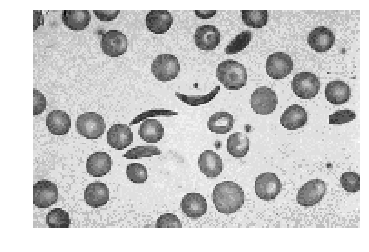

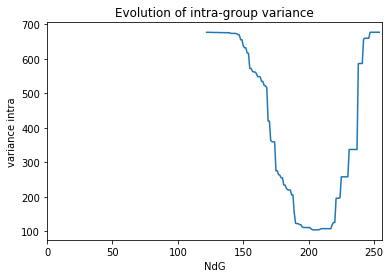

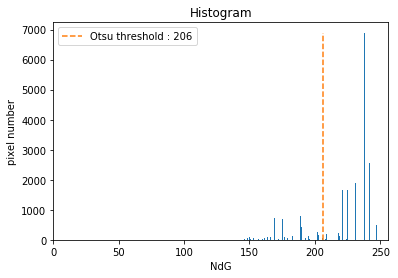

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from skimage import io
import skimage
import numpy as np 


# Compute Otsu threshold 
def otsu(image): 
    histo = skimage.exposure.histogram(image)
    var_intra = []
    nbr_pix_total = image.shape[0] * image.shape[1]
    borne_inf = histo[1][0]
    borne_sup = histo[1][-1]
    for seuil in range(borne_inf, borne_sup):
        nbr_pixel_0 = len(image[image <= seuil])
        nbr_pixel_1 = len(image[image > seuil])
        # compute variance
        sigma0 = np.var(image[image <= seuil])
        sigma1 = np.var(image[image > seuil])
        # compute var_intra
        var_intra.append(nbr_pixel_0 / nbr_pix_total * sigma0 + nbr_pixel_1 / nbr_pix_total * sigma1)
    index = np.argmin(var_intra)
    otsu_seuil = histo[1][index]
    
    return otsu_seuil, var_intra, borne_inf, borne_sup

# Plot the evolution of the variance intra to see the min value  
def plot_var_intra_evolution(image):
    seuil, var_intra, inf, sup = otsu(image)
    plt.figure()
    plt.xlim(xmin=0, xmax=256)
    plt.plot(np.arange(inf,sup), var_intra)
    plt.xlabel('NdG')
    plt.ylabel('variance intra')
    plt.title('Evolution of intra-group variance')


# Plot image's histogram and and visualize Otsu's threshold 
def plot_histo_and_view_otsu_threshold(image):
    
    seuil, var_intra, inf, sup = otsu(image)
    
    plt.figure()
    plt.xlim(xmin=0, xmax=256)
    y, x, _ = plt.hist(image.ravel(), bins=256)
    plt.title('Histogram')

    plt.plot([seuil, seuil], [0, max(y)], '--', label='Otsu threshold : '+str(seuil))
    plt.xlabel('NdG')
    plt.ylabel('pixel number')
    plt.legend()



cell_im = io.imread('cell.png')

print('The original image :')
plt.imshow(cell_im, cmap = plt.get_cmap('gray'))
plt.axis('off')
plot_var_intra_evolution(cell_im)
plot_histo_and_view_otsu_threshold(cell_im)

In the previous visualizations, we can clearly understand Otsu's algo. 
We calculate the intra variance for each possible threshold (cf. Evolution of intra variance (figure 2)) and the minimum value will be our good threshold. 
When viewing the histogram, the value found for the 'cell' image appears consistent when looking at the histogram (good séparation of two groups).
So we will be able to binarize this image with the threshold found. (respecting the fact of saying: background -> pixel at 0). 

We notice that the algorithm gives us a good threshold in this case because the histogram is bimodal. The threshold separates the bottom and the object well as we can see on the image below.

Binarized image with Otsu threshold :


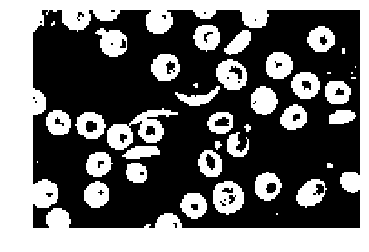

In [2]:
from skimage.util import invert

def seuillage(image, seuil):
    n = np.shape(image)
    if (len(n) == 3) : 
        image = image * 255
        image[image < seuil] = 0.
        image[image >= seuil] = 255.
        image = image / 255
    else : 
        image[image < seuil] = 0.
        image[image >= seuil] = 255.
    return image
 
print('Binarized image with Otsu threshold :')
seuil, var, inf, sup = otsu(cell_im)
image_bin = seuillage(cell_im, seuil)
plt.imshow(invert(image_bin), cmap = plt.get_cmap('gray'))
plt.axis('off')
plt.show()

### Convex component 


**Goal** : find group of pixel connect, called connected components 

The principle of connected-component analysis is to group all the pixels in contact in the image under the same label. 

- We start from a binary image 
- And we get an image in which each "object" is identified

One parameter to take in consideration is the connection of the pixels (argument **neighbors** in the morphology.label function below. 

We have a choice between 4-connectedness or 8-connectedness.

In our example with the cells, I decided to take 8-connections so as not to "create a separation" from the same cell.

There are then 40 connected components in our example below.

If we have fun counting the cells by hand to check, we can notice that the number corresponds to only a few errors. 

40


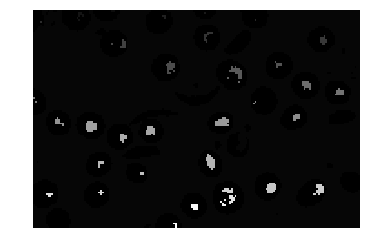

In [3]:
from skimage import morphology
from skimage import segmentation


labels = morphology.label(cell_im, neighbors = 8, background=0, return_num=True)

print(labels[1])
plt.imshow(labels[0], cmap = plt.get_cmap('gray'))
plt.axis('off')
plt.show()

The original image :


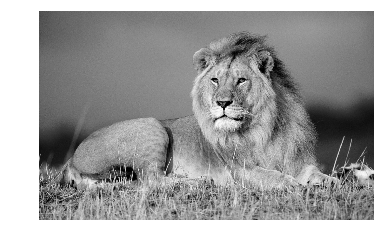

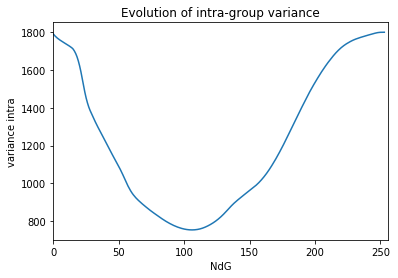

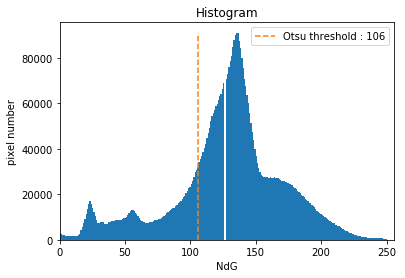

In [4]:
lion_im = io.imread('lion.jpg')

print('The original image :')
plt.imshow(lion_im, cmap = plt.get_cmap('gray'))
plt.axis('off')
plot_var_intra_evolution(lion_im)
plot_histo_and_view_otsu_threshold(lion_im)

Binarized image with Otsu threshold :


(-0.5, 2879.5, 1799.5, -0.5)

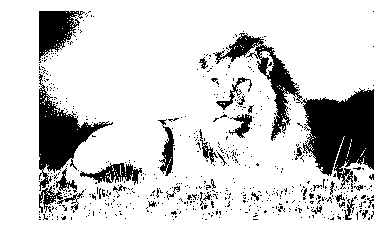

In [5]:
print('Binarized image with Otsu threshold :')
seuil, var, inf, sup = otsu(lion_im)
image_bin = seuillage(lion_im, seuil)
plt.imshow(image_bin, cmap = plt.get_cmap('gray'))
plt.axis('off')

With the example of the lion image, a human can recognize the object of the binarized image. However, the Otsu thresholding for a non-bimodal image, is not really efficient.

Here the histogram of the image is composed of 3 peaks, the threshold will therefore have a value that goes 'misclassified'.

Indeed, some pixels that should have been background are classified with the object and vice versa. 

Let's do an analysis of the connected components on this image. At first glance, this analysis does not work well because, for example, a part of the sky is detected as an object here. 

1771


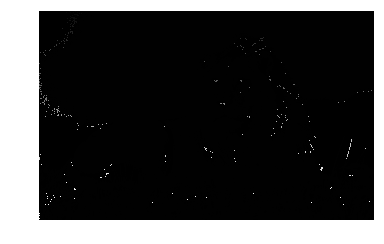

In [6]:
labels = morphology.label(image_bin, neighbors = 8, background=0, return_num=True)

print(labels[1])
plt.imshow(labels[0], cmap = plt.get_cmap('gray'))
plt.axis('off')
plt.show()

And indeed, there are 1771 connected components. 
An absurd value because on a bimodal image the Otsu method does not allow to distinguish object and background.

# 2) Preprocessing

### Morphological Image Processing

On the **text.bmp** image, we can observe that, first, the numbers or the letters are not really clear, small white spots come noisy the written line. And secondly, we notice some small black spots around the letters. 

The goal will be to remove these imperfections as much as possible through morphological image processing :

- Erosion : 
 - small objects disappear
 - division into several objects
 - object size decreases

- Dilation : 
  - Make holes disappear
  - link object
  - object size increases 
  
- Opening (Erosion then dilation): 
  - cleans the image
  
- Closing ( dilation and erosion):
  - fill in the holes 
  - shape smoothing
  - agglomerate 


The idea will be to remove the noise from the image, in other words remove the small black dots around the letters. Then, we will see if it is possible to make the writings more clear and continuous. 

To do this, we all immediately eliminate dilation and erosion because these 2 methods will change the size of the objects.

So first, we will apply the opening to clean the image and then we will use closing to make the writing sharper. 

For these methods, it is also necessary to choose a structuring element. The choice of our structuring element depends on the image we have. Indeed, with the image **text.bmp**, it does not seem judicious to take a circle as a structuring element.  It is better to choose a structuring element in the 'sense' of letters and numbers. So I decided to take a rectangle. 

In terms of the operations I will do, I immediately eliminate dilation and erosion because they are not adapted to clean my image, indeed these methods will change the size of letters and numbers so not wise in our case. 

I decide to first apply an opening to clean and remove small impurities in my image. Then I apply a closing that will allow me to fill the holes in the letters and numbers. 

We can see the result below: 

/home/pierre/anaconda3/lib/python3.7/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


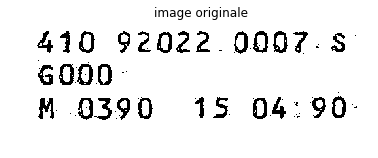

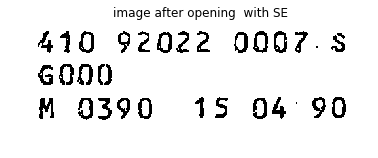

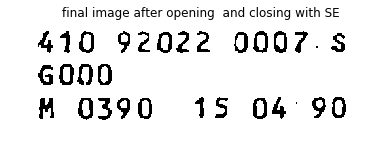

In [7]:
text = io.imread('text.bmp')

text = invert(text)

plt.figure(1)
plt.imshow(text, cmap=plt.cm.Greys)
plt.axis('off')
plt.title('image originale')

from skimage.morphology import rectangle
es = rectangle(3,2)
plt.figure(2)
plt.title('image after opening  with SE')
ope = morphology.opening(text, es)
plt.imshow(ope, cmap=plt.cm.Greys)
plt.axis('off')

es2 = rectangle(4,3)
plt.figure(3)
plt.title('final image after opening  and closing with SE')
clo = morphology.closing(ope, es2)
plt.imshow(clo, cmap=plt.cm.Greys)
plt.axis('off')
plt.show()

# 3) Edge detection  

**Difference of Gaussian(DoG)**

**DoG** is a method of edge deection that consists in subtracting a fuzzy version of an image from another less fuzzy version. 

In the case of grayscale images, blurred images are obtained with a Gaussian filter. 

A Gaussian filter can be seen as a low-pass filter, hence the observed blur effect. 



Gaussian Filter example : 

$\frac{1}{16} . \begin{bmatrix}
 1 & 2 & 1\\ 
 2 & 4 & 2\\ 
 1 & 2 & 1
\end{bmatrix} $

By subtracting 2 images filtered by a Gaussian filter (with different SD), we then have the equivalent of a bandpass filter.


Then, we then obtain the contours of an image.

In [8]:
def DoG(image): 
     return skimage.filters.gaussian(image, sigma=10.0) -  skimage.filters.gaussian(image, sigma=3.0)

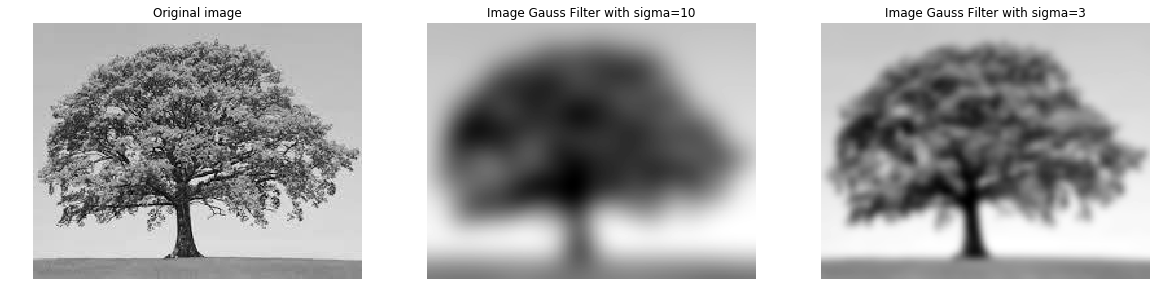

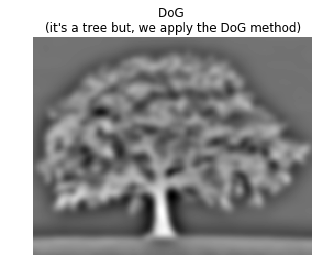

In [9]:
tree_im = io.imread('tree.jpeg')

plt.figure(figsize=(20,10))

ax = plt.subplot("131")
ax.set_title('Original image')
ax.imshow(tree_im, cmap = plt.get_cmap('gray'))
ax.axis('off')

ax = plt.subplot("132")
ax.set_title("Image Gauss Filter with sigma=10")
tree_gauss1 = skimage.filters.gaussian(tree_im, sigma=10.0)
ax.imshow(tree_gauss1, cmap=plt.cm.gray)
ax.axis('off')

ax = plt.subplot("133")
ax.set_title("Image Gauss Filter with sigma=3")
tree_gauss2 = skimage.filters.gaussian(tree_im, sigma=3.0)
ax.imshow(tree_gauss2, cmap=plt.cm.gray)
ax.axis('off')

plt.figure(2)
plt.title("DoG \n(it's a tree but, we apply the DoG method)")
tree_edge = DoG(tree_im)
plt.imshow(tree_edge, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

**Gradient**

The gradient of an image is the partial derivative of the grayscale function.

To get the edges of an image, we will apply a gradient filter : 

- in the x direction : \begin{bmatrix}
 -1 & 0 & 1\\ 
 -1 & 0 & 1\\ 
 -1 & 0 & 1
\end{bmatrix} 




- in the y direction : \begin{bmatrix}
 -1 & -1 & -1\\ 
 0 & 0 & 0\\ 
 1 & 1 & 1
\end{bmatrix} 

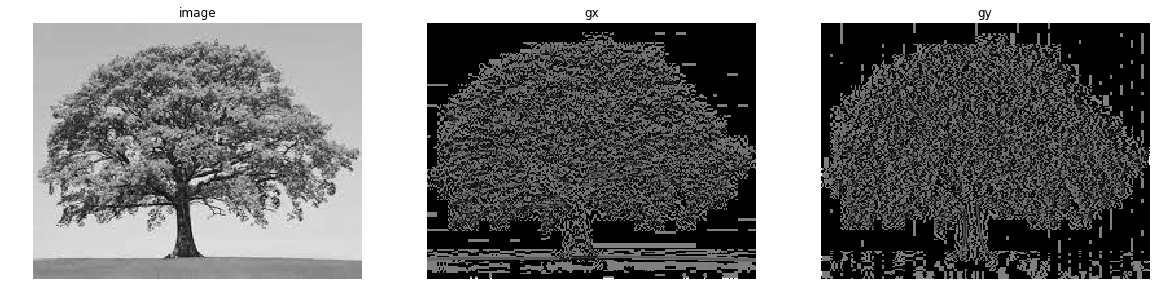

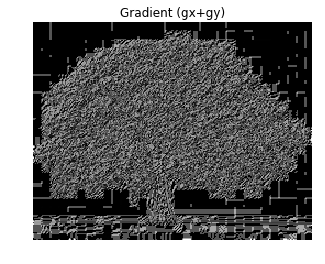

In [10]:
gx, gy = np.gradient(tree_im)

# plot
plt.figure(figsize=(20,10))

ax = plt.subplot("131")
ax.axis("off")
ax.imshow(tree_im, cmap=plt.cm.gray)
ax.set_title("image")

ax = plt.subplot("132")
ax.axis("off")
ax.imshow(gx, cmap=plt.cm.gray)
ax.set_title("gx")

ax = plt.subplot("133")
ax.axis("off")
ax.imshow(gy, cmap=plt.cm.gray)
ax.set_title("gy")
plt.show()

plt.figure()
plt.title("Gradient (gx+gy)")
plt.axis('off')
plt.imshow(gx+gy, cmap=plt.cm.gray)

**Sobel filter**

Sobel flter is another method of edges detection. 

The construction of this filter is simple : 

Gaussian filter $+$ Gradient filter $=$ Sobel filter


In x : \begin{bmatrix}
 -1 & 0 & 1\\ 
 -2 & 0 & 2\\ 
 -1 & 0 & 1
\end{bmatrix} 


In y : \begin{bmatrix}
 -1 & -2 & -1\\ 
 0 & 0 & 0\\ 
 1 & 2 & 1
\end{bmatrix} 

Let's see how this filter is applied to our image : 

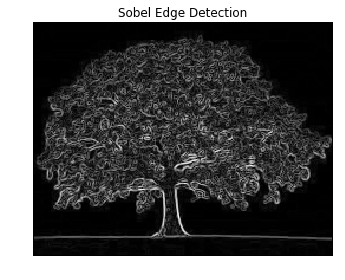

In [11]:
from skimage.filters import sobel

image = tree_im

edge_sobel = sobel(image)

plt.figure()
plt.imshow(edge_sobel, cmap=plt.cm.gray)
plt.title('Sobel Edge Detection')
plt.tight_layout()
plt.axis('off')
plt.show()

# 4) Moravec  

**Moravec** is a method used to detect points of interest in an image. 

The idea of the Moravec detector is to consider the neighbor of a pixel (a window) and determine the average intensity patterns in the neighbor considered when the window moves in different directions. If we decide to take a window of 8 neighbors, the principle of the method is to make, in each pixel, the difference in square with the 8 neighbors. This translates into the following formula:  

$E(x,y)= \sum_{i=-n}^{n} \sum_{j=-n}^{n} (I(x+i,y+j)-I(x,y))^{2}$



I wanted to make this detector with matrix operations to avoid making a loop but I had problems with dimensions. So I made a loop but the result doesn't seem very coherent because we should have, in this example, the key points on the tree but, here, the key points are located anywhere...

So I used moravec function in skimage to get an idea of the result of the method, which looks a little like contour detection in the case of my tree image. 

It should be noted that on uniform zones, the detector returns 0.


In [12]:
def moravec(image, n): 
    def E(x,y,n):
        res = 0
        for i in range(-n,n+1): 
            for j in range(-n,n+1): 
                res = res + (image[x+i, y+j] - image[x,y])**2
        return res
            
    for x in range(1, image.shape[0]-n):
        for y in range(1, image.shape[1]-n): 
            image[x,y] = E(x,y,n)
            
    return image

/home/pierre/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in ubyte_scalars
  


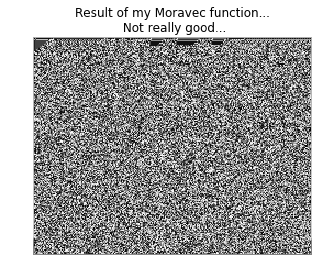

In [13]:
tree_im = io.imread('tree.jpeg')


mora_tree = moravec(tree_im, 1)
plt.title('Result of my Moravec function...\n Not really good...')
plt.imshow(mora_tree, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

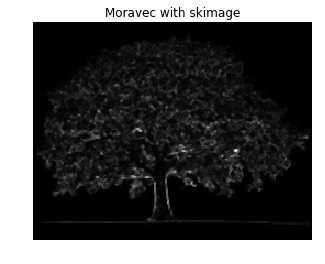

In [14]:
tree_im = io.imread('tree.jpeg')

from skimage.feature import corner_moravec

mora_tree = corner_moravec(tree_im)
plt.title('Moravec with skimage')
plt.imshow(mora_tree, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

# 5) The Hough transform


Goal -> Detection of lines in an image from a binarized image. 


/home/pierre/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Binarized image with Otsu threshold :


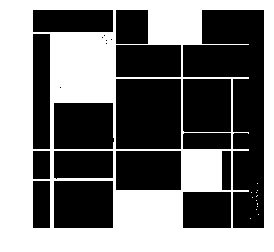

In [16]:
from skimage.transform import resize

tab = io.imread('tab.jpeg')
image = resize(tab, (100,100), anti_aliasing=True)

print('Binarized image with Otsu threshold :')
seuil, var, inf, sup = otsu(tab)
image_bin = seuillage(tab, seuil)
plt.imshow(invert(image_bin), cmap = plt.get_cmap('gray'))
plt.axis('off')
plt.show()

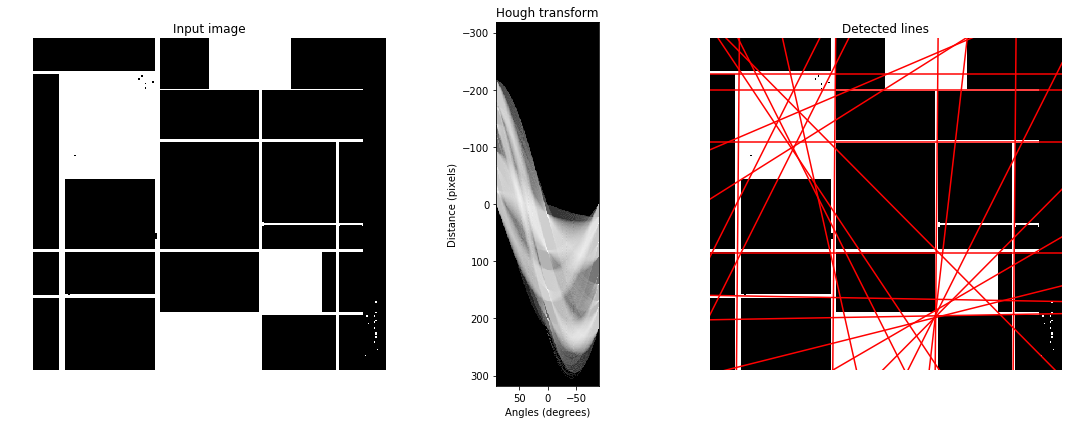

In [17]:
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)

image = invert(image_bin)

# Classic straight-line Hough transform
h, theta, d = hough_line(image)

# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(image, cmap= plt.get_cmap('gray'))
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(np.log(1 + h),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
             cmap=plt.cm.gray, aspect=1/1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(image, cmap=plt.cm.gray)
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - image.shape[1] * np.cos(angle)) / np.sin(angle)
    ax[2].plot((0, image.shape[1]), (y0, y1), '-r')
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

plt.tight_layout()
plt.show()